# Stage 7 AI training: Evaluate many rotational frames

This stage works with the **final model** and evaluates its **performance in many rotational frames**.

In [8]:
# Import packages:
import MLQDM.MLmodel as ML_MLmodel
import MLQDM.timewindows as ML_twdw
import tensorflow as tf

# Check available GPU:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load original data and general parameters
Load data from files (many segments) and store information in dataframes, one for each segment. The original data is in the **Laboratory rotational frame (RF1)**.

There are two possible sets of target labels, coming for the 'linear approximation' of 'physical model' approaches regarding the interpolated positions. You must choose one as {interp} for the training stage:
* **'lin_approx'** : linear approximation.
* **'phys_model'** : physical model based on acceleration profile.

In [2]:
# Choose Z-position interpolation method:
interp = 'phys_model' # 'phys_model' or 'lin_approx'

# Prepare files information:
data_path =  '../Data/' # Datafiles path
gen_pars_path = 'ML_parameters/'

# Load data, general hyperparameters and rotational frames:
data, hypers, RFs = ML_MLmodel.load_data_and_gen_pars(
    data_path,gen_pars_path,interp=interp,final_stage=True)

## Generate time windows

### Load original data

Each data segment is processed into time windows with a fixed time length (or equivalently, fixed number of points). The distribution of training and testing datasets is chosen here. The validation dataset is included within the training dataset.

Summary for time windows within training and testing datasets:

Number of points for every time window: 40
Time resolution: 0.1000 s

 --------------------  Training dataset  -------------------- 

time_0_to_59min: 35719 points, 59 min
time_420_to_595min: 105475 points, 175 min
time_600_to_717min: 70561 points, 117 min
Total points/time: 211755 / 5.88 hours

 --------------------  Testing dataset  -------------------- 

time_240_to_419min: 107138 points, 178 min
time_60_to_239min: 107601 points, 179 min
Total points/time: 214739 / 5.96 hours


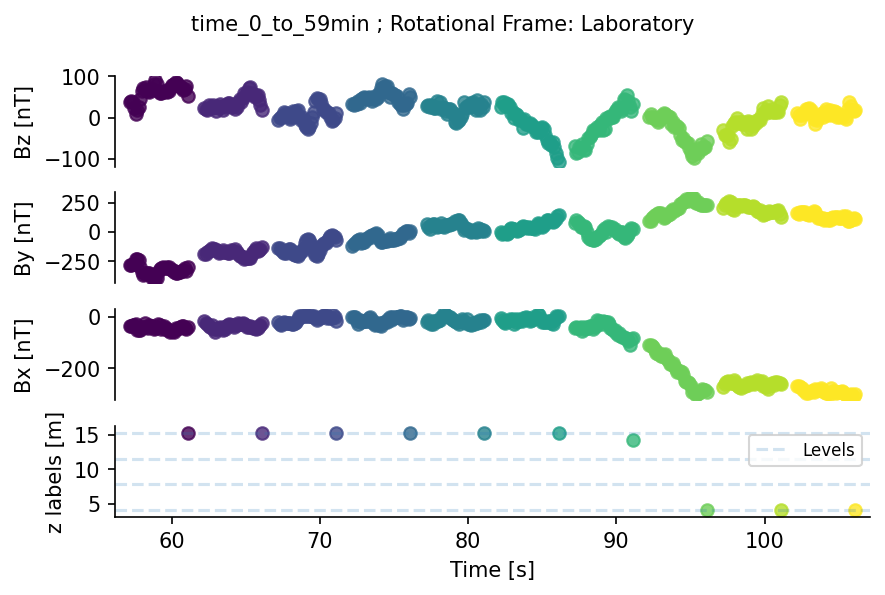

In [3]:
# Prepare time windows:
wdw_pp = 40
train_segm = [0,3,4] if interp == 'phys_model' else [2,3,4]
t_wdws_train, t_wdws_test = ML_twdw.prepare_time_windows(
    data,wdw_pp,train_segm=train_segm,instances=10,start_wdw=570,stride_pp=50)

## Prepare final ML model

The **final ML model** will be evaluated in many rotational frames (64 instances randomly generated).

From previous Stages, we've chosen the following model and hyperparameters:

* Convolutional layers: [32,8] + [32,4]
* Pooling layers: None
* 1D-Conversion layer: Flattening
* Dense layers: [1024] + [512]
* No dropout
* Optimizer: adam.
* Activation function: tanh.
* Learning rate: 5e-4.
* No data augmentation.

In [7]:
# Define additional hyperparameters:
extra_hypers = {
    "Time_Window_pp": wdw_pp,
    "Magnetic_Components": ['Bx','By','Bz'],
    "Convolutional_Network": True,
    "Conv_Layers": [[16,8],[16,4]],
    "Pool_Layers": [None,None],
    "Flatten_Average": True,
    "Dens_Layers": [1024,512],
    "Dropout_Fraction": 0,
    "Activation_Function": 'tanh',
    "Optimizer": 'adam',
    "Learning_Rate": 1e-4,
    "Model_Name": f"S7_{interp}_C8C4_NP_Flat_D1024D512",
    "p_train": 1,
    "N_augm": 0,
    "noise": [0,0,0],
}

# Combine all information:
full_hyps = hypers | extra_hypers

# Prepare rotational frame options:
RF_opts = list(RFs.values())

# Print summary for the final ML model:
final_ML_model = ML_MLmodel.ML_Model(full_hyps | {'Full_Name':'Final ML model example'})
final_ML_model.info()

------------------------------
Full name: Final ML model example
Time windows' points: 40
Input magnetic components: ['Bx', 'By', 'Bz']
Model's trainable parameters: 1019297
------------------------------


In [6]:
# Prepare file path to export results:
results_path = f'../Results/'
# Prepare file path to check on already trained models and avoid repetitions:
check_rep_model = f'../Results/Stage7_{interp}_all_Train_s1s4s5_Test_s2s3.csv'

# Train ML model:
df_results = ML_MLmodel.train_stage7(
    full_hyps,t_wdws_train,t_wdws_test,RF_opts,interpolation=interp,
    results_path=results_path,check_rep_model=check_rep_model,
    quick_timing_test=False
)